# Car Plate Character Segmenttion
### Reference："Detecting the Car Number Plate Using Segmentation" V. Lakshmi Priya 1, K. Perumal2

You'd better read this paper to get a feeling on how to detect the car plate numbers.
You can find this paper in the project papers subfolder.
We also provide a few related papers for your reference.


In [169]:
import skimage.io as io
import skimage.color as color
import skimage.morphology as morphology
import skimage.feature as feature
import skimage.measure as measure
import skimage.transform as transform
import numpy as np
import math
import os

In [170]:
from matplotlib import pyplot as plt
%matplotlib inline

There are four car plates in carplate subfolder. Your character recognition model should successfully recognize all of them in order to get full credits for this project.

# 1. Load one car plate image

In [171]:
img = io.imread('./carplate/粤B5PQ23.png')

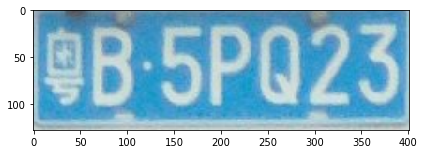

In [172]:
io.imshow(img)

# 2. Transform to Grey Image

In [173]:
img2 = color.rgb2gray(img)

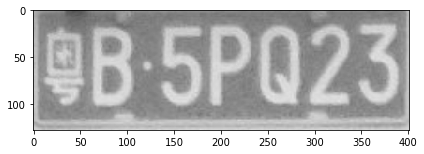

In [174]:
io.imshow(img2)

# 3. Apply Canny Edge Detection and Dilation

In [175]:
img3 = feature.canny(img2, sigma=3)

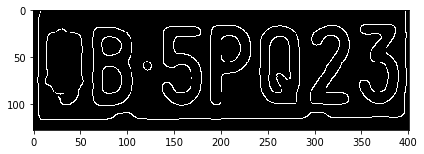

In [176]:
io.imshow(img3)

In [177]:
img4 = morphology.dilation(img3)

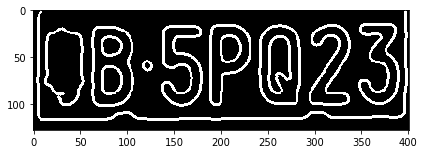

In [178]:
io.imshow(img4)

# 4. Label and Region Proposal

In [179]:
label_img = measure.label(img4)
regions = measure.regionprops(label_img)

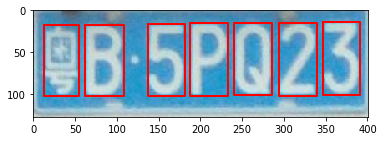

In [180]:
fig, ax = plt.subplots()
ax.imshow(img, cmap=plt.cm.gray)

def in_bboxes(bbox, bboxes):
    for bb in bboxes:
        minr0, minc0, maxr0, maxc0 = bb
        minr1, minc1, maxr1, maxc1 = bbox
        if minr1 >= minr0 and maxr1 <= maxr0 and minc1 >= minc0 and maxc1 <= maxc0:
            return True
    return False

bboxes = []
for props in regions:
    y0, x0 = props.centroid
    minr, minc, maxr, maxc = props.bbox
    
    if maxc - minc > img4.shape[1] / 7 or maxr - minr < img4.shape[0] / 3:
        continue
        
    bbox = [minr, minc, maxr, maxc]
    if in_bboxes(bbox, bboxes):
        continue
        
    if abs(y0 - img4.shape[0] / 2) > img4.shape[0] / 4:
        continue
        
    bboxes.append(bbox)
    
    bx = (minc, maxc, maxc, minc, minc)
    by = (minr, minr, maxr, maxr, minr)
    ax.plot(bx, by, '-r', linewidth=2)
    

# 5. Retrieve Each Character Image

In [182]:
bboxes = sorted(bboxes, key=lambda x: x[1])

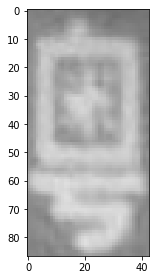

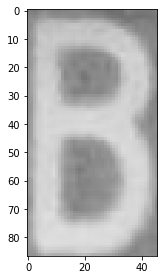

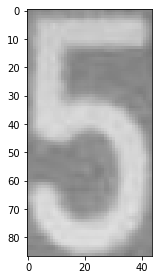

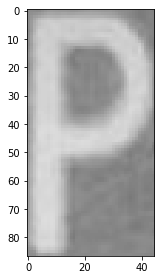

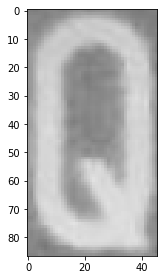

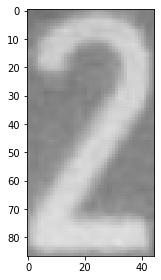

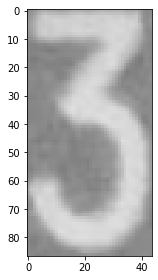

In [183]:
chars = []
for bbox in bboxes:
    minr, minc, maxr, maxc = bbox
    ch = img2[minr:maxr, minc:maxc]
    chars.append(ch)
    io.imshow(ch)
    plt.show()

# 6. Image Enhancement
In order to improve the recognition rate, it may need to do image enhancement before character recognition.

Leave this as an excrcise for you.

In [184]:
# optional -- character image enhancement

# 7. Character Recognition

In [191]:
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K

DATASET_DIR = './dataset'
classes = os.listdir(DATASET_DIR )

num_classes = len(classes)
img_rows, img_cols = 20, 20

if K.image_data_format() == 'channels_first':
    input_shape = [1, img_rows, img_cols]
else:
    input_shape = [img_rows, img_cols, 1]

# 7.1 Create a cnn model for character recognition

Here is a sample model. You can fine tune this model or build a different model to order to improve the accuracy.


In [186]:
model_char = Sequential()
model_char.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model_char.add(Conv2D(64, (3, 3), activation='relu'))
model_char.add(MaxPooling2D(pool_size=(2, 2)))
model_char.add(Dropout(0.25))
model_char.add(Flatten())
model_char.add(Dense(128, activation='relu'))
model_char.add(Dropout(0.5))
model_char.add(Dense(num_classes, activation='softmax'))

model_char.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

We use pretrained character recognition model to recognize car plate characters.

In [187]:
model_char.load_weights("./char_cnn.h5")

In [188]:
def extend_channel(data):
    if K.image_data_format() == 'channels_first':
        data = data.reshape(data.shape[0], 1, img_rows, img_cols)
    else:
        data = data.reshape(data.shape[0], img_rows, img_cols, 1)
        
    return data

In [189]:
chars2 = []
for ch in chars:
    chars2.append(transform.resize(ch, [img_rows, img_cols]))
    
chars2 = np.stack(chars2)

In [190]:
ys = np.unique(classes)

p_test = model_char.predict_classes(extend_channel(chars2))
print(' '.join([ys[p_test[i]] for i in range(len(p_test))]))

粤 B 5 P Q 2 3
